<h1>Datasketch</h1>

Implementation of probabilistic data structures that can process and search very large amount of data super fast, with little loss of accuracy.

This package contains different data sketches: <b>MinHash</b>, Weighted MinHash, HyperLogLog, HyperLogLog++.
It also provides different indexes such as <b>MinHash LSH</b>, MinHash LSH Forest and MinHash LSH Ensemble.

<h2>Install</h2>

To install datasketch using <b>pip</b>:

In [ ]:
pip install datasketch -U

<h2>MinHash</h2>

MinHash is a probabilistic data structure for estimating Jaccard similarity (Intersection over Union) between sets in linear time using a small and fixed memory space.

---
First, create the MinHash objects for a list or set of items:

In [1]:
from datasketch import MinHash

UNIL = ['UNIL','is','the','best','university','in','Switzerland']
EPFL = ['EPFL','is','the','best','university','in','Switzerland']
MIT = ['MIT','is','an','average','school','in','usa']

minUNIL, minEPFL, minMIT = MinHash(), MinHash(), MinHash()

for d in UNIL:
    minUNIL.update(d.encode('utf8'))
for d in EPFL:
    minEPFL.update(d.encode('utf8'))
for d in MIT:
    minMIT.update(d.encode('utf8'))

---
Then, compare the minHashes with the jaccard method:

In [2]:
print("Estimated Jaccard for UNIL and EPFL is", minUNIL.jaccard(minEPFL))

s1 = set(UNIL)
s2 = set(EPFL)
actual_jaccard = float(len(s1.intersection(s2)))/float(len(s1.union(s2)))
print("Actual Jaccard for UNIL and EPFL is", actual_jaccard)

Estimated Jaccard for UNIL and EPFL is 0.7421875
Actual Jaccard for UNIL and EPFL is 0.75


In [3]:
print("Estimated Jaccard for UNIL and MIT is", minUNIL.jaccard(minMIT))

s1 = set(UNIL)
s3 = set(MIT)
actual_jaccard = float(len(s1.intersection(s3)))/float(len(s1.union(s3)))
print("Actual Jaccard for UNIL and MIT is", actual_jaccard)

Estimated Jaccard for UNIL and MIT is 0.1796875
Actual Jaccard for UNIL and MIT is 0.16666666666666666


---
You can adjust the accuracy by customizing the number of permutation functions used in MinHash:

In [4]:
# This will give better accuracy than the default setting (128).
m = MinHash(num_perm=256)

The trade-off for better accuracy is slower speed and higher memory usage. Indeed, using more permutation functions means more CPU instructions for every data value hashed and more hash values to be stored.

---
You can union two MinHash objects using the <b>merge</b> function.

In [ ]:
# The makes m1 the union of m2 and the original m1.
m1.merge(m2)

---
If you are handling a lot of MinHash objects, you can use <b>datasketch.LeanMinHash</b> to reduce your memory footprint.

Lean MinHash is MinHash with a smaller memory footprint and faster deserialization, but with its internal state frozen, meaning that it cannot be updated.

Lean MinHash inherits all methods from the standard MinHash object. It does not store the permutations and the hashobj needed for updating. If a MinHash does not need further updates, convert it into a lean MinHash to save memory.

In [6]:
from datasketch import LeanMinHash

lean_minEPFL = LeanMinHash(minEPFL)
lean_minUNIL = LeanMinHash(minUNIL)

# You can compute the Jaccard similarity between two lean MinHash
lean_minUNIL.jaccard(lean_minEPFL)

0.7421875

In [7]:
# Or between a lean MinHash and a MinHash
lean_minEPFL.jaccard(minUNIL)

0.7421875

---
To create a MinHash from a LeanMinHash

In [8]:
minUNIL_from_leanMinHash = MinHash(seed=lean_minUNIL.seed, hashvalues=lean_minUNIL.hashvalues)

# Or if you want to prevent further updates on minhash
# from affecting the state of lean_minhash
minUNIL_from_leanMinHash = MinHash(seed=lean_minUNIL.seed, hashvalues=lean_minUNIL.digest())

<h2>MinHash LSH</h2>

Suppose you have a very large collection of sets. Giving a query, which is also a set, you want to find sets in your collection that have Jaccard similarities above certain threshold, and you want to do it with many other queries. 

To do this efficiently, you can create a MinHash for every set, and when a query comes, you compute the Jaccard similarities between the query MinHash and all the MinHash of your collection, and return the sets that satisfy your threshold. This approach is an O(n) algorithm, meaning the query cost increases linearly with respect to the number of sets. 

A popular alternative is to use Locality Sensitive Hashing (LSH) index. LSH can be used with MinHash to achieve sub-linear query cost - that is a huge improvement. Datasketch includes the classic version of MinHash LSH.

---

First, insert the minHashes into the LSH:

In [9]:
from datasketch import MinHashLSH

# Create LSH index
lsh = MinHashLSH(threshold=0.5, num_perm=128)
lsh.insert("minUNIL", minUNIL)
lsh.insert("minEPFL", minEPFL)
lsh.insert("minMIT", minMIT)

Then, the LSH can be queried using the <b>query</b> method:

In [10]:
result = lsh.query(minUNIL)
print("Approximate neighbours of UNIL with Jaccard similarity > 0.5", result)

Approximate neighbours of UNIL with Jaccard similarity > 0.5 ['minUNIL', 'minEPFL']


In [11]:
result = lsh.query(minMIT)
print("Approximate neighbours of MIT with Jaccard similarity > 0.5", result)

Approximate neighbours of MIT with Jaccard similarity > 0.5 ['minMIT']


<h2>Other data structures implemented in Datasketch</h2>

<h3>Weighted MinHash</h3>

Implementation of a weighted sampling method, where the probability of drawing identical samples for a pair of inputs is equal to their Jaccard similarity.

<h3>HyperLogLog and HyperLogLog++</h3>
HyperLogLog is capable of estimating the cardinality (the number of distinct values) of dataset in a single pass, using a small and fixed memory space.

HyperLogLog++ is an enhanced version of HyperLogLog by Google. It uses 64-bit hash values instead of the 32-bit used by HyperLogLog and it has a more stable bias correction scheme based on experiments on many datasets.

<h3>MinHash LSH Ensemble</h3>
Jaccard similarity is great for measuring resemblance between two sets, however, it can be a biased measure for set intersection, as large sets are penalized. We can use a better measure for intersection, called containment. It is computed as the intersection size divided by the size of one of the set.

Similar to MinHash LSH, there is an LSH index implemented in Datasketch for containment search – given a query set, find sets with containment above a certain threshold.

<h3>MinHash LSH Forest</h3>
MinHash LSH is useful for threshold queries. However, top-k queries are often more useful in some cases. LSH Forest is a general LSH data structure that makes top-k query possible for many different types of LSH indexes, which include MinHash LSH. I implemented the MinHash LSH Forest, which takes a MinHash data sketch of the query set, and returns the top-k matching sets that have the highest Jaccard similarities with the query set.

The interface of datasketch.MinHashLSHForest is similar to datasketch.MinHashLSH, however, it is very important to call index method after adding the keys. Without calling the index method, the keys won’t be searchable.

<h2>LSH time</h2>

In [26]:
from datasketch import MinHash, MinHashLSH
import time
import numpy as np

index ={}

def hash_from_set(setvals, nperm=128):
    minhash = MinHash(nperm)
    for val in setvals:
        minhash.update(val)
    return minhash

def jaccard( s1, s2):
    s1 = set(s1)
    s2 = set(s2)
    return float(len(s1.intersection(s2)))/float(len(s1.union(s2)))

hashtimes = []
lshtimes = []
lintimes = []
results1 = []
results2 = []

for n in range(1, 11):

    lsh2 = MinHashLSH(threshold=0.7, num_perm=128)
    randset = np.random.randint(0,2, size=(n*1000, 500))
    hashes = { i : hash_from_set(set(np.flatnonzero(randset[i,:])) ) for i in range(randset.shape[0])}
    
    #insert the hashes of the random sets into the LSH
    list(map(lambda args: lsh2.insert(args[0],args[1]), zip(hashes.keys(),hashes.values())))
    
    #10 random queries
    for q in list(np.random.randint(0, randset.shape[0] , size=10)):
        start = time.clock()
        
        #using the lsh
        result_rows = lsh2.query(hashes[q])
        lshtimes.append([n*1000,time.clock()-start])
        
        #using a linear search over all of the hashes
        start = time.clock()
        hashjaccard = [ hashes[q].jaccard(hashes[i]) for i in range(randset.shape[0]) ]
        sortedscores = np.argsort(hashjaccard)[::-1]
        hashtimes.append([n*1000,time.clock()-start])
        
#         print(sorted(result_rows))
#         print(sorted(list(sortedscores[:len(result_rows)])))
#         #top 100 entries vs returned results
#         score1 = jaccard(result_rows,sortedscores[:100])
#         score2 = jaccard(result_rows,sortedscores[:len(result_rows)])
        
#         print(score1)
#         print(score2)
        
#         results1.append([score1 , n*1000])
#         results2.append([score2 , n*1000])

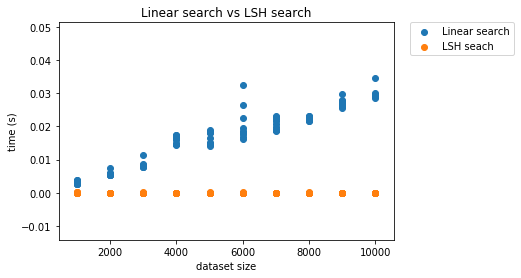

In [27]:
from matplotlib import pyplot as plt
%matplotlib inline

hashtimes = np.asarray(hashtimes)
lshtimes = np.asarray(lshtimes)
plt.title('Linear search vs LSH search')
plt.scatter(hashtimes[:,0],hashtimes[:,1], label="Linear search" )
plt.scatter(lshtimes[:,0], lshtimes[:,1], label="LSH seach")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('time (s)')
plt.xlabel('dataset size')

plt.show()

# print('jaccard of results vs n elements')
# plt.scatter(results1[0], results1[1])
# plt.scatter(results2[0], results2[1])
# plt.show()